In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [3]:
##
#This file aims to read the dump.lummps data to load the 
#positions of different atoms at different t
#at each time t, i can have a table telling me the 3D location of each atom
##
#After that, I will calculate the distance correlation defined as
#for x= Si, y=O
#for x= Si, y = Si
#for x= O, y = O

$$
\sum_i \sum_j x_i y_j
$$


In [5]:
#Current position data are obtained using an absolute reference frame
#instead of a relateive body frame

#This is simply importing all of the 
#infomation as a table, same as 
#the one you see when you open the .lammpstr file
def read_lammps_data(filename):
    data = []  # to store the data temporarily
    current_timestep = None
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if 'Timestep:' in line:
                current_timestep = int(line.split()[-1])  # extract timestep
            elif line.isdigit():
                continue  # this is just the number of atoms, skip it
            else:
                parts = line.split()
                if len(parts) == 4:  # make sure it's the right format
                    atom_type = int(parts[0])
                    x, y, z = map(float, parts[1:])
                    data.append([current_timestep, atom_type, x, y, z])
    
    # Create a DataFrame
    columns = ['Timestep', 'Atom Type', 'x', 'y', 'z']
    df = pd.DataFrame(data, columns=columns)
    return df

#The data I will read
filename = r'C:\Users\Eric\Desktop\Yb Simulation\Zihagn_good_tool\Classical_MD_coord_visual\dump.lammpstrj'
df = read_lammps_data(filename)
print(df.head())  # show the first few rows

In [2]:
#This uses diction to store the data
#at each time, there is a table describing the 
#3D location of each atom
def read_lammps_data_partitioned(filename):
    timestep_data = {}  # Dictionary to store data by timestep
    current_timestep = None
    
    with open(filename, 'r') as file:
        for line in file:
            line = line.strip()
            if 'Timestep:' in line:
                current_timestep = int(line.split()[-1])  # extract timestep
                timestep_data[current_timestep] = []  # Initialize an empty list for this timestep
            elif line.isdigit():
                continue  # this is just the number of atoms, skip it
            else:
                parts = line.split()
                if len(parts) == 4:  # make sure it's the right format
                    atom_type = int(parts[0])
                    x, y, z = map(float, parts[1:])
                    timestep_data[current_timestep].append([atom_type, x, y, z])
    
    # Convert lists to DataFrames
    for timestep, data in timestep_data.items():
        columns = ['Atom Type', 'x', 'y', 'z']
        timestep_data[timestep] = pd.DataFrame(data, columns=columns)
    
    return timestep_data

In [67]:
#The data I will read
filename = r'C:\Users\Eric\Desktop\Yb Simulation\Zihagn_good_tool\Classical_MD_coord_visual\dump.lammpstrj'
df = read_lammps_data(filename)
print(df.head())  # show the first few rows

   Timestep  Atom Type        x        y         z
0         0          2  0.00000  7.95642   4.74695
1         0          2  4.63304  0.00000  11.35800
2         0          2  0.00000  4.63304   4.74695
3         0          2  7.95642  0.00000  11.35800
4         0          2  0.00000  4.63304   8.47514


In [3]:
#This is to read the data as dictionary
filename = r'C:\Users\Eric\Desktop\Yb Simulation\Zihagn_good_tool\Classical_MD_coord_visual\dump.lammpstrj'
timestep_tables = read_lammps_data_partitioned(filename)

In [4]:
timestep_tables[3000]

,Atom Type,x,y,z
0,2,-0.209150,8.306060,4.99552
1,2,5.161440,12.442800,11.21160
2,2,12.384600,5.064870,4.91384
3,2,8.598060,-0.154925,12.16890
4,2,12.556400,4.287980,8.39599
...,...,...,...,...
91,1,1.051900,12.536800,8.36250
92,1,-0.011418,10.444200,11.98370
93,1,1.296280,12.269100,5.33324
94,1,0.019112,1.029580,12.01290


In [14]:
class correlate:
    def __init__(self,dick):
        self.diction = dick
        keys_list = list(self.diction.keys())
        stepsize = np.abs(keys_list[0]-keys_list[1])
        print(f"Initialized successfully. Use x.run(atom, atom, time) to get correlation.\n"
      f"atom = 1 means Si. atom = 0 means O.\n"
      f"Available time steps range from: {keys_list[0]} to {keys_list[-1]}, stepsize: {stepsize}")

    def run(self,fucker1,fucker2,time):
        #fucker means the type of atoms
        # 1 means Si
        # 2 means o
        hibertsapce = self.diction[time]
        fuckerspace1 = hibertsapce[hibertsapce['Atom Type'] == fucker1]
        fuckerspace2 = hibertsapce[hibertsapce['Atom Type'] == fucker2]
        result = 0 
        #calculate the sum: Sum_{i,j} x_i * x_j
        for i in range(fuckerspace1.shape[0]):
            for j in range(fuckerspace2.shape[0]):
                if i==j:
                    continue
                v_i = fuckerspace1.iloc[i][['x', 'y', 'z']].to_numpy()
                v_j = fuckerspace2.iloc[j][['x', 'y', 'z']].to_numpy()
                result += np.dot(v_i-v_j, v_i-v_j)
        return result
                
        

In [15]:
test = correlate(timestep_tables)

Initialized successfully. Use x.run(atom, atom, time) to get correlation.
atom = 1 means Si. atom = 0 means O.
Available time steps range from: 0 to 10398000, stepsize: 3000


In [99]:
10398000/3000

3466.0

In [103]:
c1  = np.array([]) #11
c2  = np.array([]) #12
c3  = np.array([]) #22
for i in tqdm(range(3466), desc='Processing'):
    c1 = np.append(c1,test.run(1,1,i*3000))
    c2 = np.append(c2,test.run(1,2,i*3000))
    c3 = np.append(c2,test.run(2,2,i*3000))
    

Processing:   0%|                                                                   | 3/3466 [00:21<6:59:28,  7.27s/it]


KeyboardInterrupt: 

In [16]:
c1  = np.array([]) #11
for i in tqdm(range(346), desc='Processing'):
    c1 = np.append(c1,test.run(1,1,i*3000*10))

Processing: 100%|██████████| 346/346 [02:43<00:00,  2.11it/s]


In [12]:
import matplotlib.pyplot as plt

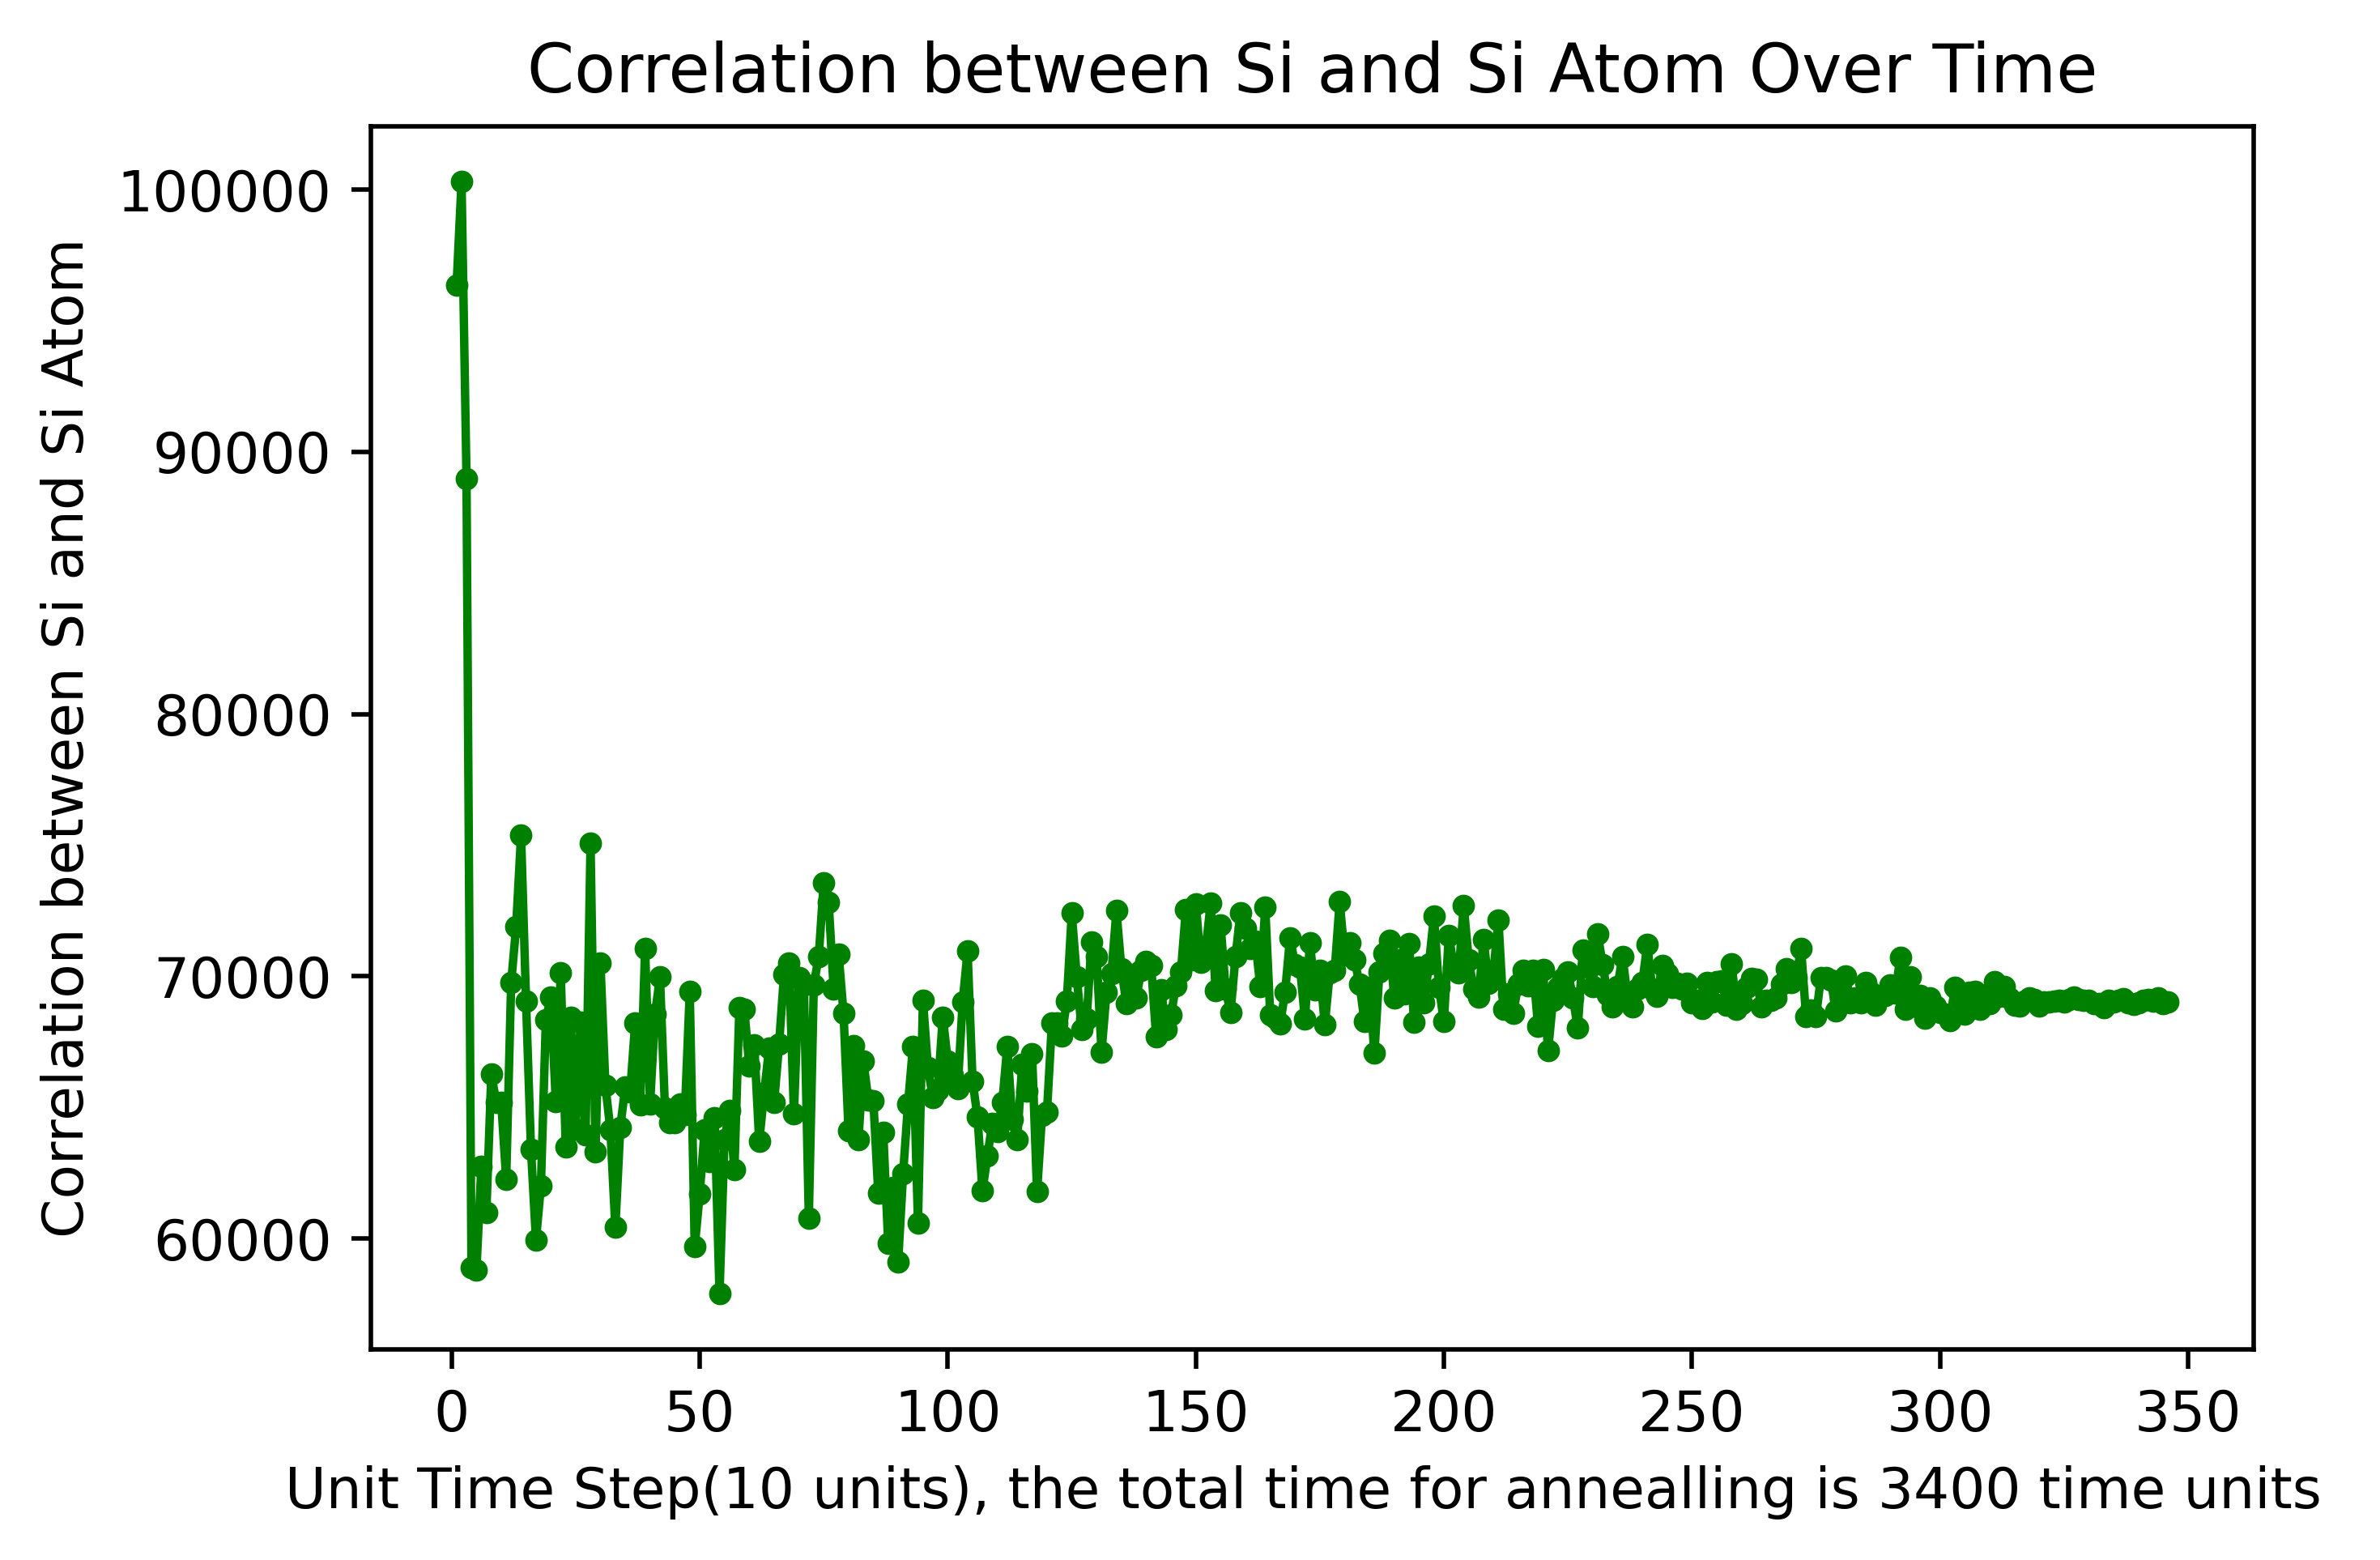

In [25]:
# Creating the x-axis data. It ranges from 1 to the length of c1.
x = list(range(1, len(c1) + 1))
plt.figure(dpi=500)

# Creating the plot
  # Set the size of the plot
plt.plot(x, c1, marker='o',color = "green",markersize=3)  # Plot x and c1 with circle markers
plt.title('Correlation between Si and Si Atom Over Time')  # Title of the plot
plt.xlabel('Unit Time Step(10 units), the total time for annealling is 3400 time units ')  # Label for the x-axis
plt.ylabel('Correlation between Si and Si Atom')  # Label for the y-axis
plt.grid(False)  # Show grid lines for better readability
plt.show()